# Process Datasets

The aim of this script is to create a word level dataset with an author id as their labels.

[Manual steps]

1. Download [BanglaWriting](https://data.mendeley.com/datasets/r43wkvdk4w/1) Dataset
2. Download [BN-HTRd](https://data.mendeley.com/datasets/743k6dm543/1) Dataset

[Script]

1. Combine the two datasets into one
2. Create train/val/test splits

## Imports

In [15]:
import os
import shutil
import json
from glob import glob
from pathlib import Path
import itertools
from typing import Callable
from tqdm import tqdm

from IPython.display import display
from PIL import Image

import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

In [2]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 10em; }</style>"))

## 1. Combine the two datasets

In [4]:
DATA_DIR = "data/"

# Unzip the downloaded file and move the `1`,`2`,...`150` folders in this directory
BNHTRD_DIR = "data/bnhtrd/"

# Unzip the downloaded file and move the `converted` and `raw` folders in this directory
BANGLAWRITING_DIR = "data/banglawriting/converted/"

COMBINED_ALL_DIR = "data/combined/all/"
WRITER_ALL_LABELS = "data/combined/all.json"

In [5]:
if not os.path.exists(COMBINED_ALL_DIR):
    os.makedirs(COMBINED_ALL_DIR)

# BanglaWriting

The BanglaWriting dataset has 260 handwritten pages, each written by a different writer. [Paper](https://arxiv.org/pdf/2011.07499.pdf)

In [6]:
def get_boxes(annotation_path: str, 
              filter : Callable[[dict], bool] = None) -> list[float]:
    
    if filter is None:
        filter = lambda x: True
        
    boxes = []
    with open(annotation_path, "r") as file:
        annotation = json.loads(file.read())
        boxes = [x["points"] for x in annotation["shapes"] if filter(x)]
        boxes = [list(itertools.chain(*x)) for x in boxes]
    
    return boxes

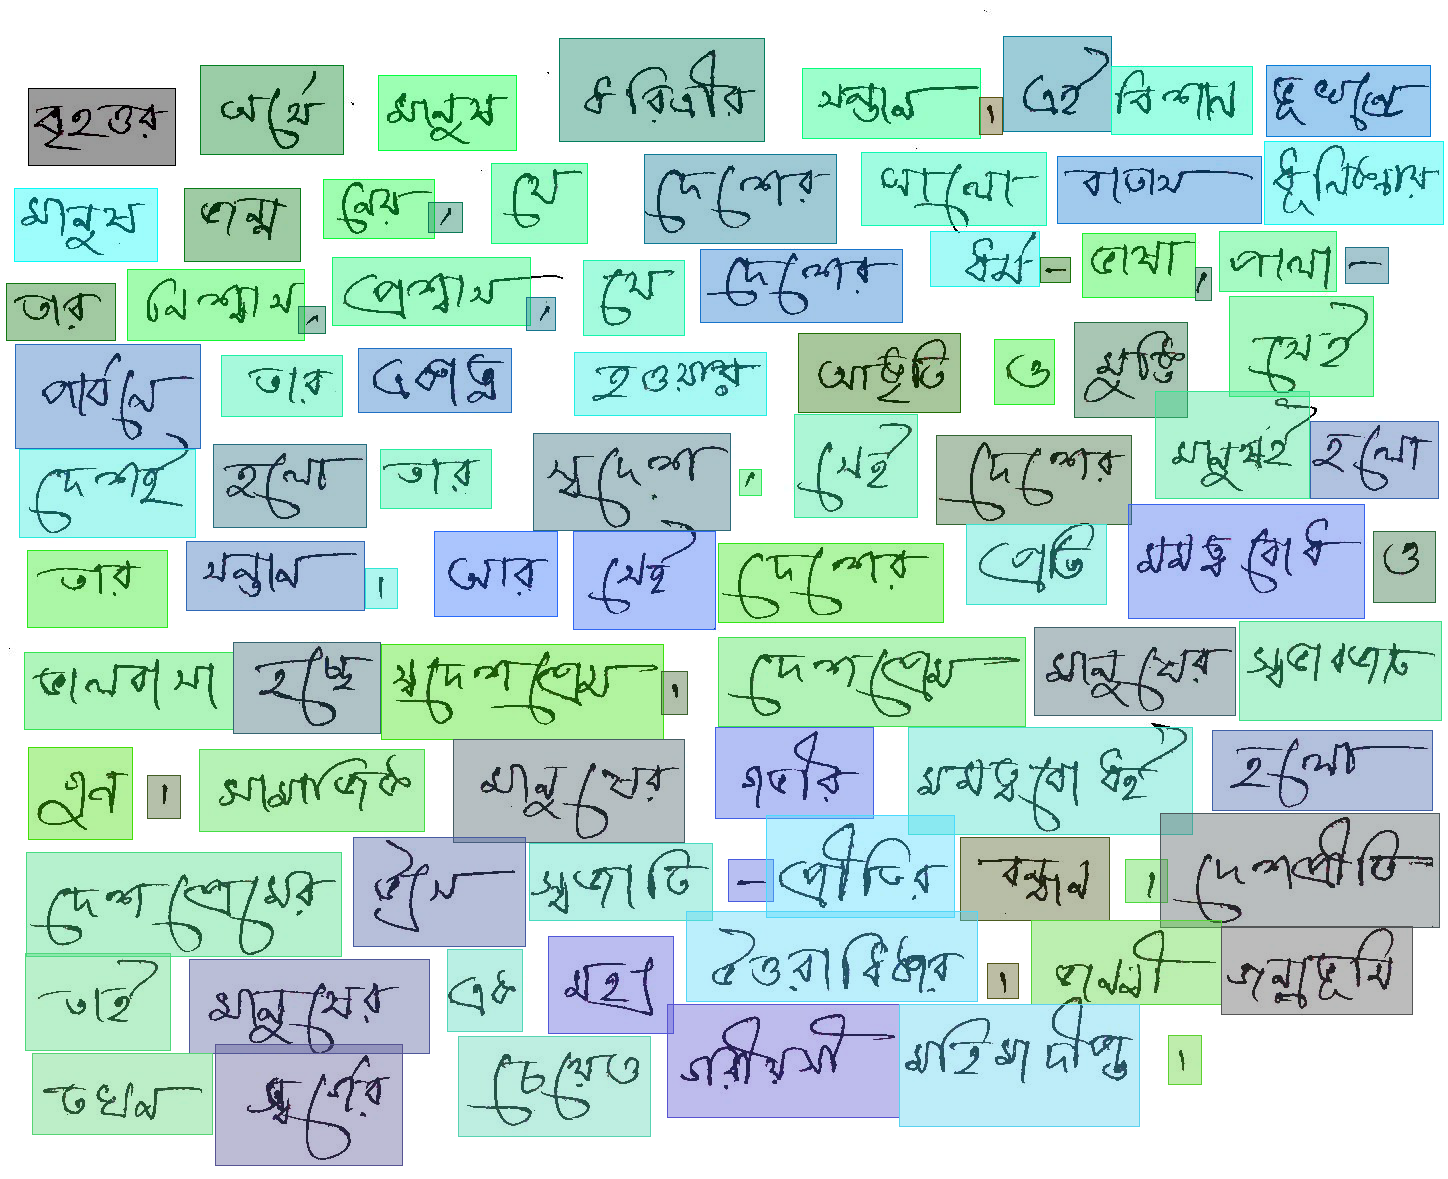

In [7]:
img = read_image(glob(BANGLAWRITING_DIR + '/*.jpg')[0])
boxes = get_boxes(glob(BANGLAWRITING_DIR + '/*.json')[0])
boxes = torch.tensor(boxes, dtype=torch.int)
img = draw_bounding_boxes(img, boxes, width=1, fill=True)
img = torchvision.transforms.ToPILImage()(img)
  
display(img)

For BanglaWriting dataset, we choose to use the converted images already provided in the dataset. As the images are entire pages, we need to crop the images from the provided labels.

In [8]:
prefix = "bw_" # BanglaWriting
word_id = 0
writer_id = 0

writer_annotations = []
error_count = 0
for image_path in tqdm(glob(BANGLAWRITING_DIR + "/*.jpg")):
    image = Image.open(image_path)
    annotation_path = image_path.split(".jpg")[0] + ".json"
    # Exclude the boxes with single characters (e.g. punctuation)
    boxes = get_boxes(annotation_path,
                      filter = lambda x: len(x["label"])>1)

    for box in boxes:
        word_name = prefix + str(word_id) + ".jpg"
        save_dir = os.path.join(COMBINED_ALL_DIR, word_name)
        
        writer_annotations.append(
            {
                "image" : word_name,
                "writer_id" : writer_id
            }
        )
        
        try:
            image.crop(box).save(save_dir)
            word_id += 1
        except:
            # Some boxes are wrongly annotated
            error_count += 1
    
    writer_id += 1
    
with open(WRITER_ALL_LABELS, "w") as file:
    file.write(json.dumps(writer_annotations))

print(f"Succesfully cropped {word_id+1} words.")
print(f"Errors processing {error_count} words.")

100%|██████████| 260/260 [00:14<00:00, 17.71it/s]

Succesfully cropped 17960 words.
Errors processing 1 words.


# BN-HTRd

The BN-HTRd dataset has 150 different writers. Each numbered sub-directory in the dataset directory represents each writer.

In [18]:
prefix = "bn_" # BN-HTRd
word_id = 0

# BanglaWriting ends at index 259 (Total 260 writers).
offset_writer_id = 259

writer_annotations = []
error_count = 0
for image_path in tqdm(glob(BNHTRD_DIR+"/*/Words/*/*.JPG")):
    image = Image.open(image_path)
    try:
        author = int(
                Path(image_path)
                .stem
                .split("_")[0]
            )
    except:
        # Some file names are wrongly formatted
        error_count += 1
    
    word_name = prefix + str(word_id) + ".jpg"
    save_dir = os.path.join(COMBINED_ALL_DIR, word_name)
    shutil.copyfile(image_path, save_dir)
    
    writer_annotations.append(
        {
            "image" : word_name,
            "writer_id" : offset_writer_id + author
        }
    )
    
    word_id += 1

100%|██████████| 79620/79620 [00:43<00:00, 1818.35it/s]


In [25]:
previous_content = []
with open(WRITER_ALL_LABELS, "r") as file:
    contents = file.read()
    if len(contents):
        previous_content = json.loads(contents)

annotations = previous_content
annotations.extend(writer_annotations)
with open(WRITER_ALL_LABELS, "w") as file:    
    file.write(json.dumps(annotations))

print(f"Succesfully copied {word_id+1} words.")
print(f"Error copying copied {error_count} words.")

Succesfully copied 79621 words.
Error copying copied 1 words.
